# Loop Workflow Example 1

* High level approach to making a 3D model from just a bounding box (in Australia only for now). Simply run all the cells of the notebook. 
* This requires an internet connection to access remote data, for a local data version see Example 3.

In [1]:
#if not already installed:
#!conda install -c loop3d map2loop loopstructural pyamg meshio
#!pip install loopstructuralvisualisation[jupyter]

# note on versions:

## map2loop version = v3.2.0
## LoopStructural version = 1.6.4
## LoopProjectFile = 0.2.2
## loopstructural-visualisation = 0.1.10

### Optional:
Create a config dictionary that specifies the column names and description texts to process the shape files

In [2]:
config_dict = {
    "structure" : {
        "orientation_type": "strike",
        "dipdir_column": "strike",
        "dip_column": "dip",
        "description_column": "feature",
        "bedding_text": "Bed",
        "overturned_column": "structypei",
        "overturned_text": "BEOI",
        "objectid_column": "geopnt_id",
    },
    "geology" : {
        "unitname_column": "unitname",
        "alt_unitname_column": "code",
        "group_column": "group_",
        "supergroup_column": "supersuite",
        "description_column": "descriptn",
        "minage_column": "min_age_ma",
        "maxage_column": "max_age_ma",
        "rocktype_column": "rocktype1",
        "alt_rocktype_column": "rocktype2",
        "sill_text": "is a sill",
        "intrusive_text": "intrusive",
        "volcanic_text": "volcanic",
        "objectid_column": "objectid",
        "ignore_codes": ["cover"],
    },
    "fault" : {
        "structtype_column": "feature",
        "fault_text": "Fault",
        "dip_null_value": "0",
        "dipdir_flag": "num",
        "dipdir_column": "dip_dir",
        "dip_column": "dip",
        "orientation_type": "dip direction",
        "dipestimate_column": "dip_est",
        "dipestimate_text": "gentle,moderate,steep",
        "name_column": "name",
        "objectid_column": "objectid",
    },
    "fold" : {
        "structtype_column": "feature",
        "fold_text": "Fold axial trace",
        "description_column": "type",
        "synform_text": "syncline",
        "foldname_column": "name",
        "objectid_column": "objectid",
    }
}

## Map2Loop

In [3]:
import os
from map2loop.project import Project
from map2loop.m2l_enums import VerboseLevel, Datatype
from map2loop.sorter import SorterAlpha, SorterAgeBased, SorterUseHint, SorterUseNetworkX, SorterMaximiseContacts, SorterObservationProjections
from map2loop.thickness_calculator import ThicknessCalculatorAlpha, InterpolatedStructure, StructuralPoint
from map2loop.sampler import SamplerSpacing


# Set the region of interest for the project
bbox_3d = {
    "minx": 515687.31005864,
    "miny": 7493446.76593407,
    "maxx": 562666.860106543,
    "maxy": 7521273.57407786,
    "base": -3200,
    "top": 3000,
}

# Specify minimum details (Australian state, projection, bounding box and output file)
# Optional: the config information manually created in the config_dict can be used by
# setting the parameter config_dictionary
loop_project_filename="wa_output.loop3d"
proj = Project( 
    use_australian_state_data = "WA",
    config_dictionary = config_dict,
    working_projection = "EPSG:28350",
    bounding_box = bbox_3d,
    verbose_level = VerboseLevel.NONE,
    loop_project_filename = loop_project_filename,
    overwrite_loopprojectfile = True
)

# Specify
proj.set_ignore_lithology_codes(["cover", "Fortescue_Group", "A_FO_od"])

# Set the distance between sample points for arial and linestring geometry
proj.set_sampler(Datatype.GEOLOGY, SamplerSpacing(200.0))
proj.set_sampler(Datatype.FAULT, SamplerSpacing(200.0))

# Choose which thickness calculator to use
# proj.set_thickness_calculator(ThicknessCalculatorAlpha())
proj.set_thickness_calculator(InterpolatedStructure())
# proj.set_thickness_calculator(StructuralPoint())

# Choose which stratigraphic sorter to use or run_all with "take_best" flag to run them all
# proj.set_sorter(SorterAlpha())
# proj.set_sorter(SorterAgeBased())
# proj.set_sorter(SorterUseHint())
# proj.set_sorter(SorterUseNetworkX())
# proj.set_sorter(SorterMaximiseContacts())
# proj.set_sorter(SorterObservationProjections())
column = [
    # youngest
    'Turee_Creek_Group',
    'Boolgeeda_Iron_Formation',
    'Woongarra_Rhyolite',
    'Weeli_Wolli_Formation',
    'Brockman_Iron_Formation',
    'Mount_McRae_Shale_and_Mount_Sylvia_Formation',
    'Wittenoom_Formation',
    'Marra_Mamba_Iron_Formation',
    'Jeerinah_Formation',
    'Bunjinah_Formation',
    'Pyradie_Formation',
    'Fortescue_Group',
    # oldest
]
proj.run_all(user_defined_stratigraphic_column=column)

C:\Users\angel\anaconda3\envs\ls\Lib\site-packages\map2loop\__init__.py:112: UserWarning: dependencies.txt not found. No dependencies checked for map2loop.
  warnings.warn(

 



C:\Users\angel\anaconda3\envs\ls\Lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


## Extract Information from project

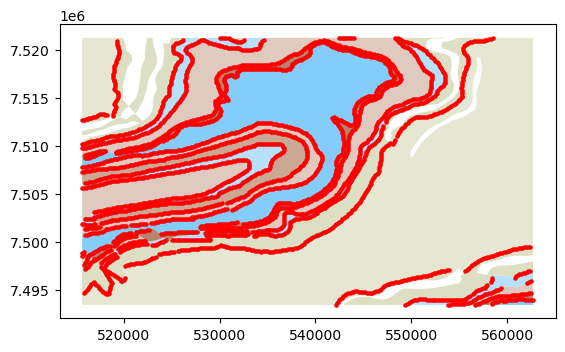

In [4]:
# Draw overlay of point data on geology map (can also try 'contacts','orientations','faults')
proj.draw_geology_map(overlay="contacts")

In [5]:
# Extract map2loop estimate of the stratigraphic column
print(proj.stratigraphic_column.column)

['Turee_Creek_Group', 'Boolgeeda_Iron_Formation', 'Woongarra_Rhyolite', 'Weeli_Wolli_Formation', 'Brockman_Iron_Formation', 'Mount_McRae_Shale_and_Mount_Sylvia_Formation', 'Wittenoom_Formation', 'Marra_Mamba_Iron_Formation', 'Jeerinah_Formation', 'Bunjinah_Formation', 'Pyradie_Formation', 'Fortescue_Group']


In [6]:
# Save geology map as a raster map in a specified projection (useful for overlays on online maps)
proj.save_geotiff_raster(filename="geol.tif", projection="epsg:3857")

Projection is : epsg:3857


## Loop Structural

In [7]:
import LoopProjectFile as LPF
import LoopStructural
from LoopStructural.modelling.input.project_file import LoopProjectfileProcessor as LPFProcessor
from LoopStructural.visualisation import Loop3DView
import numpy as np

# LoopStructural Modelling
fault_params = {
    'interpolatortype':'FDI',
    'nelements':1e4,
}
foliation_params = {
    'interpolatortype':'FDI' , # 'interpolatortype':'PLI',
    'nelements':1e5,  # how many tetras/voxels
    'regularisation':5,
}
projFile = LPF.ProjectFile(loop_project_filename)
processedData = LPFProcessor(projFile)

In [8]:
processedData.thicknesses

{'Turee_Creek_Group': inf,
 'Boolgeeda_Iron_Formation': 436.53165648221125,
 'Woongarra_Rhyolite': 620.048633031626,
 'Weeli_Wolli_Formation': 446.2193181653078,
 'Brockman_Iron_Formation': 861.1421464230768,
 'Mount_McRae_Shale_and_Mount_Sylvia_Formation': 240.25476954067562,
 'Wittenoom_Formation': 486.0072783721006,
 'Marra_Mamba_Iron_Formation': 332.4297770640236,
 'Jeerinah_Formation': 991.8848915029621,
 'Bunjinah_Formation': -1.0}

In [9]:
processedData.foliation_properties['sg'] = foliation_params
processedData.fault_properties['interpolatortype'] = fault_params['interpolatortype']
processedData.fault_properties['nelements'] = fault_params['nelements']

model = LoopStructural.GeologicalModel.from_processor(processedData)
model.nsteps=np.array([100,100,50])
model.update()

                    Defaulting to a dip of 90vertical fault
                          projected onto fault surface estimating from fault normal
                    Defaulting to a dip of 90vertical fault
                          projected onto fault surface estimating from fault normal
                    Defaulting to a dip of 90vertical fault
                          projected onto fault surface estimating from fault normal
                    Defaulting to a dip of 90vertical fault
                          projected onto fault surface estimating from fault normal
                    Defaulting to a dip of 90vertical fault
                          projected onto fault surface estimating from fault normal
                    Defaulting to a dip of 90vertical fault
                          projected onto fault surface estimating from fault normal
                    Defaulting to a dip of 90vertical fault
                          projected onto fault surface estimating from fault

  0%|          | 0/25 [00:00<?, ?it/s]

In [10]:
view = Loop3DView(model)
view.plot_model_surfaces()
view.display()

Widget(value='<iframe src="http://localhost:52050/index.html?ui=P_0x24a6ad6de10_0&reconnect=auto" class="pyvis…